In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import sklearn as sk
from sklearn import preprocessing, model_selection
from scipy import stats

In [317]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D

In [350]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical

In [59]:
df_org = pd.read_csv('WISDM_ar_v1.1_raw.csv')

In [60]:
df_group = [group for _, group in df_org.groupby('user_id')]

In [61]:
def plot_activity(data, name: str = ''):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, data['time'], data['acc_x'], 'X-Axis')  # x
    plot_axis(ax1, data['time'], data['acc_y'], 'Y-Axis')  # y
    plot_axis(ax2, data['time'], data['acc_z'], 'Z-Axis')  # z
    plt.suptitle(name)
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(top=0.90)
    plt.show()


def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title, fontsize=10)

    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


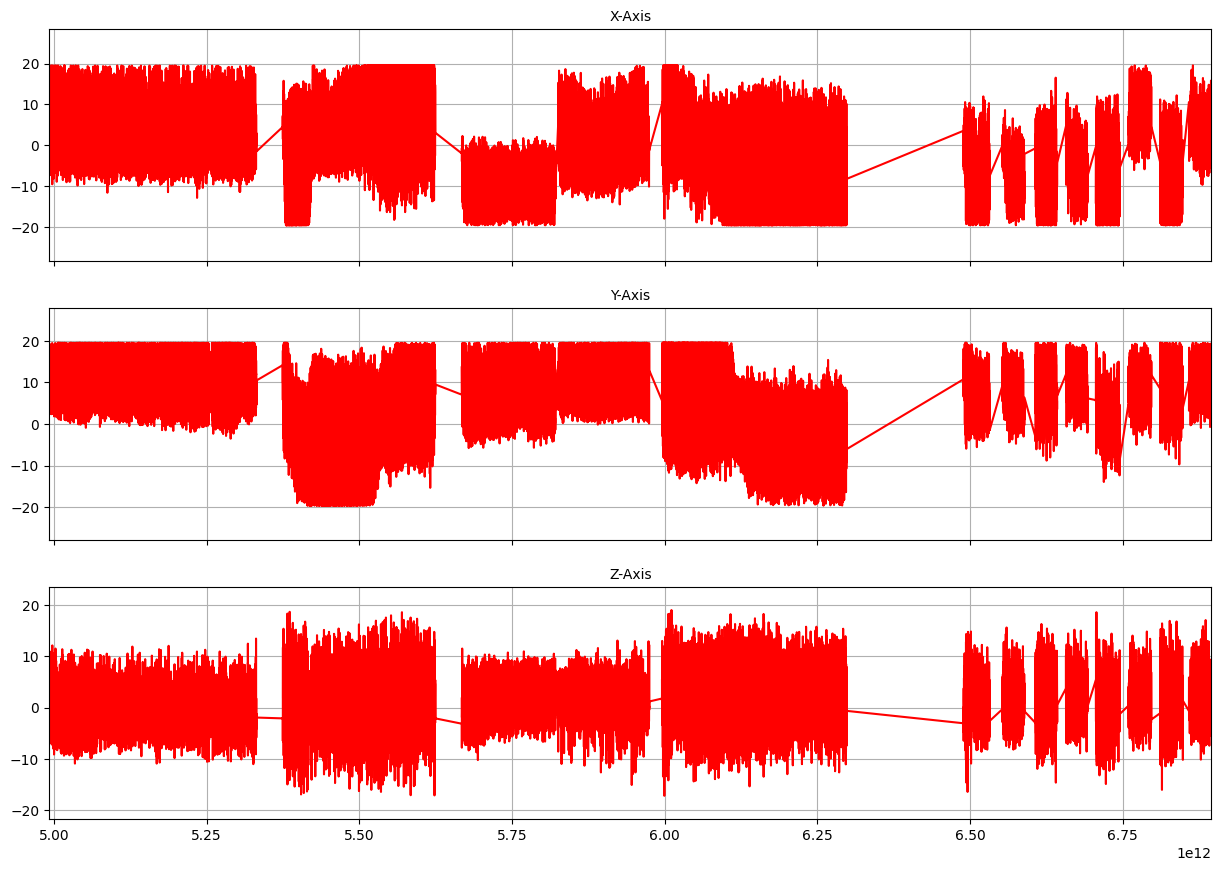

Text(0.5, 0.92, 'Trajectory 2')

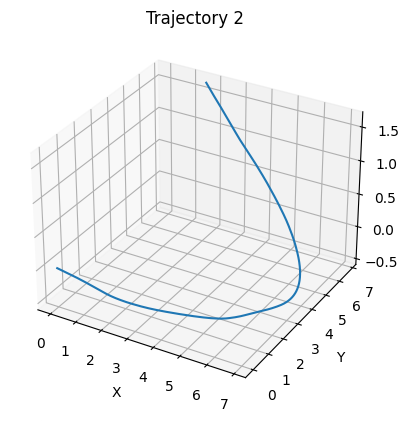

In [62]:
data = df_group[0]

accel_x = data.iloc[:, 3]
accel_y = data.iloc[:, 4]
accel_z = data.iloc[:, 5]

plot_activity(data)

# Time
dt = data.iloc[2, 2] - data.iloc[1, 2]

# Integrate accelerometer data to get velocity
vel_x = np.cumsum(accel_x) * dt
vel_y = np.cumsum(accel_y) * dt
vel_z = np.cumsum(accel_z) * dt

# Integrate velocity to get displacement
disp_x = np.cumsum(vel_x) * dt
disp_y = np.cumsum(vel_y) * dt
disp_z = np.cumsum(vel_z) * dt

fig, axs = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax = axs
# ax.plot3D(position_x, position_y, position_z)
ax.plot3D(disp_x, disp_y, disp_z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Trajectory {}'.format(1 + 1))

In [320]:
df = df_org

LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

# Normalization
scalar = preprocessing.MinMaxScaler()
df[['acc_x']] = scalar.fit_transform(np.array(df[['acc_x']]))
df[['acc_y']] = scalar.fit_transform(np.array(df[['acc_y']]))
df[['acc_z']] = scalar.fit_transform(np.array(df[['acc_z']]))

In [352]:
def chunks(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst.iloc[i:i + chunk_size, 3:6], stats.mode(lst.iloc[i:i + chunk_size, 6])[0]


time_steps = 80  # 80 steps => 4 sec (0.05 * 80 = 4)

# Splitting features into consecutive chunks
X, Y = zip(*chunks(df, time_steps))

# Splitting the dataset into training and validation sets
x_train, x_val, y_train, y_val = model_selection.train_test_split(X, Y, test_size=0.2, shuffle=False)

## Deep Neural Network

In [353]:
input_shape = 80 * 3

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)


x_train shape: (10702, 240)
y_train shape: (10702,)


In [348]:
X[0]

,acc_x,acc_y,acc_z
0,0.478144,0.814390,0.515198
1,0.622404,0.778664,0.526603
2,0.619649,0.769046,0.500337
3,0.480209,0.961070,0.579135
4,0.465749,0.799962,0.685236
...,...,...,...
75,0.472635,0.759427,0.495498
76,0.561463,0.983399,0.615078
77,0.642029,0.575647,0.531441
78,0.445436,0.808550,0.433289


In [346]:
x_train[0]

array([0.47814363, 0.8143895 , 0.515198  , 0.6224036 , 0.778664  ,
       0.526603  , 0.6196493 , 0.7690456 , 0.50033695, 0.4802094 ,
       0.9610701 , 0.5791352 , 0.465749  , 0.79996186, 0.68523633,
       0.5304766 , 0.43171442, 0.3372107 , 0.4802094 , 0.76114476,
       0.64721966, 0.48296377, 0.84633636, 0.6814347 , 0.28258353,
       0.7824427 , 0.63270414, 0.51980346, 0.5292725 , 0.5442289 ,
       0.28843656, 0.9882078 , 0.57153183, 0.5315095 , 0.6405712 ,
       0.57809836, 0.44818988, 0.41934788, 0.4948072 , 0.34076956,
       0.6673653 , 0.29539233, 0.6430614 , 0.94870365, 0.7191058 ,
       0.6544232 , 0.56980723, 0.5763703 , 0.4561087 , 0.7041214 ,
       0.46543068, 0.5848754 , 0.83740497, 0.7415702 , 0.44440264,
       0.350645  , 0.24389698, 0.5655948 , 0.755305  , 0.2556476 ,
       0.5859083 , 0.8394661 , 0.5414641 , 0.48296377, 0.59213567,
       0.5967611 , 0.43751672, 0.53717333, 0.5044842 , 0.4054972 ,
       0.9882078 , 0.6676104 , 0.47538927, 0.41144705, 0.38490

In [354]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [356]:
n_classes = le.classes_.size
y_train_hot = to_categorical(y_train, 6)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (10702, 6)


In [360]:
x_train.shape

(10702, 240)

In [361]:
y_train_hot.shape

(10702, 6)

In [363]:
time_steps, 3

(80, 3)

In [357]:
model = Sequential()
model.add(Reshape((time_steps, 3), input_shape=(240, )))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax'))

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 80, 3)             0         
                                                                 
 dense_16 (Dense)            (None, 80, 100)           400       
                                                                 
 dense_17 (Dense)            (None, 80, 100)           10100     
                                                                 
 dense_18 (Dense)            (None, 80, 100)           10100     
                                                                 
 flatten_4 (Flatten)         (None, 8000)              0         
                                                                 
 dense_19 (Dense)            (None, 6)                 48006     
                                                                 
Total params: 68606 (267.99 KB)
Trainable params: 6860

In [358]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])


In [359]:
BATCH_SIZE = 400
EPOCHS = 50

history = model.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)


Epoch 1/50


2024-03-01 20:12:37.480135: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-01 20:12:37.546255: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0e657db300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 20:12:37.546282: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-03-01 20:12:37.551072: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-01 20:12:37.645325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:447] Loaded runtime CuDNN library: 8.5.0 but source was compiled with: 8.9.4.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building f

FailedPreconditionError: Graph execution error:

Detected at node Adam/StatefulPartitionedCall_6 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/user/.local/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib64/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib64/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib64/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/usr/local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/usr/local/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_24652/693779484.py", line 4, in <module>

  File "/home/user/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/user/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/user/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/user/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/user/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/user/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/home/user/.local/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize

  File "/home/user/.local/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients

  File "/home/user/.local/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients

  File "/home/user/.local/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients

  File "/home/user/.local/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn

  File "/home/user/.local/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1340, in apply_grad_to_update_var

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node Adam/StatefulPartitionedCall_6}}]] [Op:__inference_train_function_66911]

## Processing data on 5 minute walking

In [14]:
def load_df(file_name):
    data_frame = pd.read_csv(file_name)
    refresh_rate = 100
    arr = np.arange(0, len(data_frame) // refresh_rate + 1, 1 / refresh_rate)
    to_trim = len(data_frame) - len(arr)
    data_frame.insert(0, 'time', arr[:to_trim])
    data_frame.insert(0, 'activity', ['walking'] * (len(data_frame)))
    data_frame.insert(0, 'user_id', np.full(len(data_frame), df_org['user_id'].max()))
    data_frame.drop(data_frame.columns[-3:], axis=1, inplace=True)
    data_frame.rename(columns={'accel_x': 'acc_x'}, inplace=True)
    data_frame.rename(columns={'accel_y': 'acc_y'}, inplace=True)
    data_frame.rename(columns={'accel_z': 'acc_z'}, inplace=True)
    return data_frame

In [54]:
walking_left = load_df('experiments/5minwalk/device_red_B1A104.csv')
walking_right = load_df('experiments/5minwalk/device_red_B0A105.csv')

stationary_left = load_df('experiments/stationary/device_red_B1A104.csv')
stationary_right = load_df('experiments/stationary/device_red_B0A105.csv')

In [52]:
# Extract from second 50 to 150
begin_time = 50
end_time = 150
REFRESH_RATE = 100

left_sensor_filtered = walking_left[(walking_left['time'] >= begin_time) & (walking_left['time'] <= end_time)]
right_sensor_filtered = walking_right[(walking_right['time'] >= begin_time) & (walking_right['time'] <= end_time)]

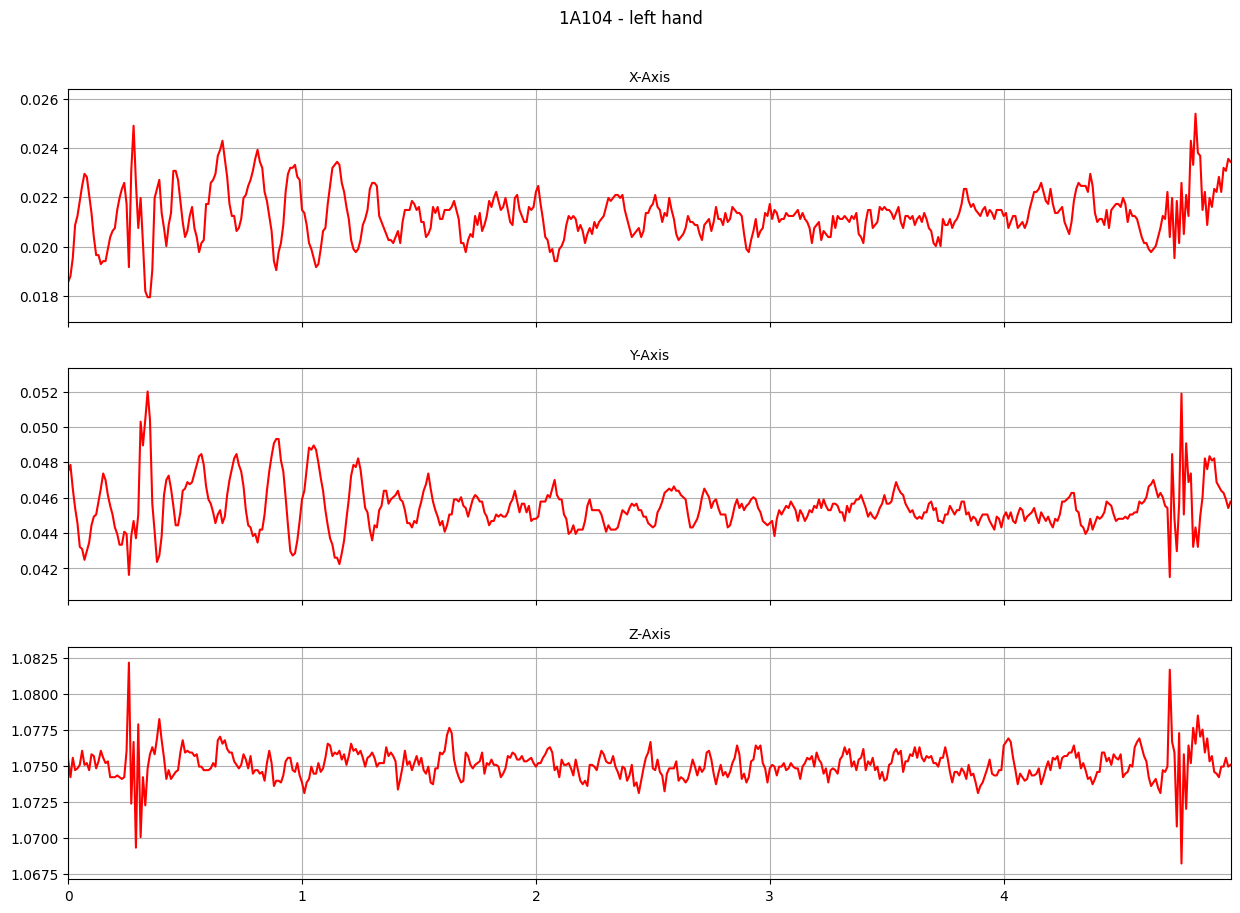

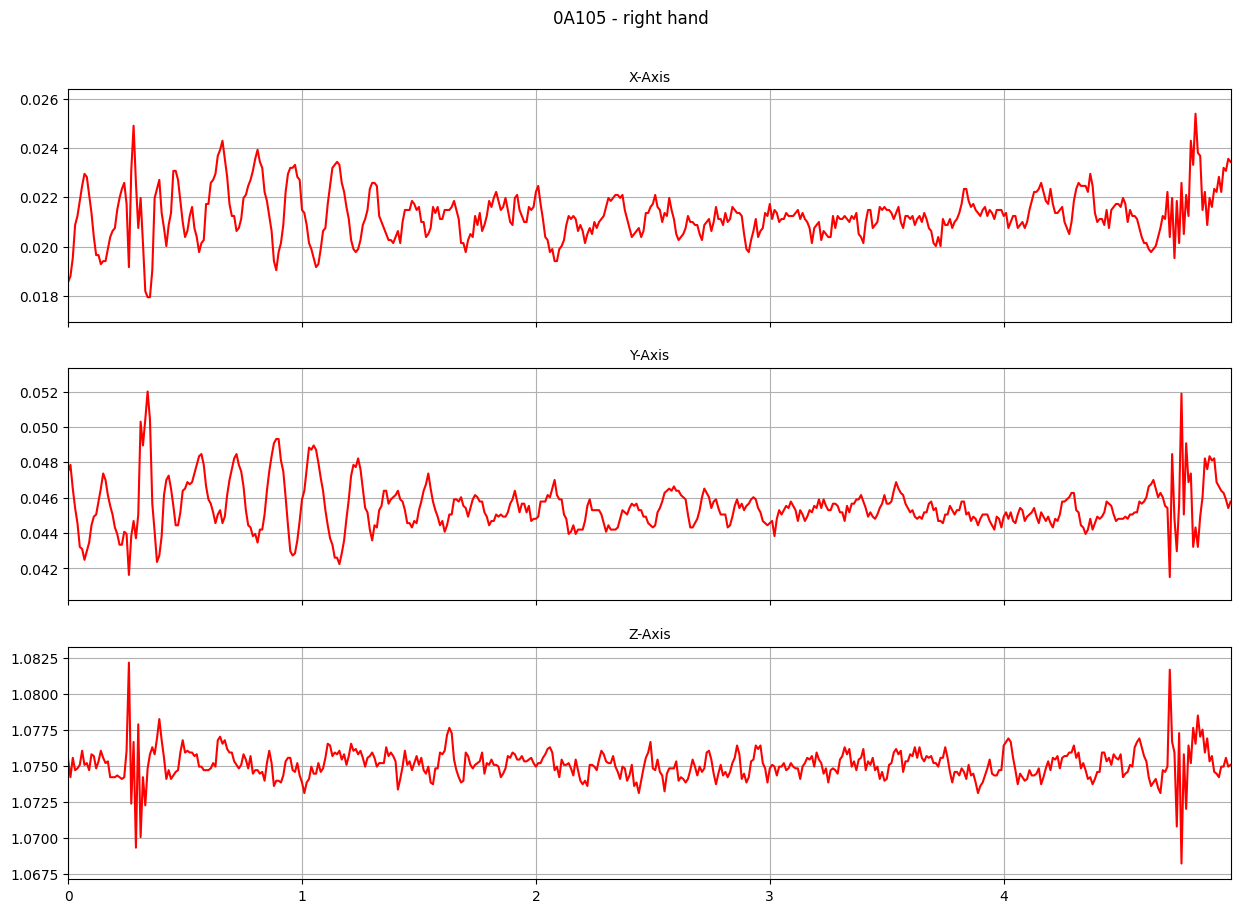

In [55]:
plot_activity(data=stationary_left, name='1A104 - left hand')
plot_activity(data=stationary_left, name='0A105 - right hand')